In [2]:
# Setup and imports
import sys
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set project root
project_root = Path("/home/Plutonium/Documents/BioinfoMidterm")
os.chdir(project_root)
sys.path.insert(0, str(project_root / "scripts"))

print(f"Working directory: {os.getcwd()}")

# Core imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import subprocess

# Statistical imports
from scipy.stats import chi2_contingency, entropy
from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.multitest import fdrcorrection

# Project imports
from config import PATHS, SITUATIONAL_FILTERS
from utils import count_variants

print("All imports successful!")

Working directory: /home/Plutonium/Documents/BioinfoMidterm
All imports successful!


## Step 1: Load Filtered Data from Step 02

In [3]:
# Input: LD-pruned pfile from step 02
INPUT_PFILE = str(PATHS.PLINK_LD_PRUNED)
SAMPLES_CSV = str(PATHS.EAS_SAMPLES_CSV)
OUTPUT_DIR = str(PATHS.OUTPUT_DIR)

print(f"Input pfile: {INPUT_PFILE}")
print(f"Samples CSV: {SAMPLES_CSV}")

# Count variants
n_variants = count_variants(INPUT_PFILE)
print(f"Variants after LD pruning: {n_variants}")

# Load sample information
samples_df = pd.read_csv(SAMPLES_CSV, header=None)
samples_df.columns = ["sample", "pop", "super_pop"]
print(f"\nSamples: {len(samples_df)}")
print(f"Populations: {samples_df['pop'].unique()}")
print(f"\nPopulation distribution:")
print(samples_df['pop'].value_counts())

Input pfile: 1000genomes/output/EAS_FINAL_DATA_FOR_FST
Samples CSV: 1000genomes/EAS_subpopulation_samples.csv
Variants after LD pruning: 390615

Samples: 306
Populations: ['KHV' 'CHB' 'JPT']

Population distribution:
pop
JPT    104
CHB    103
KHV     99
Name: count, dtype: int64


## Step 2: Export Genotypes to VCF and Convert to Matrix

In [4]:
# Export pfile to VCF for genotype extraction
vcf_output = str(PATHS.OUTPUT_DIR / "statistical_analysis_temp")

print("Exporting to VCF format...")
cmd = f"plink2 --pfile {INPUT_PFILE} --export vcf --out {vcf_output}"
result = subprocess.run(cmd, shell=True, capture_output=True, text=True)

if result.returncode == 0:
    print(f"VCF exported: {vcf_output}.vcf")
else:
    print(f"Error: {result.stderr}")

Exporting to VCF format...
VCF exported: 1000genomes/output/statistical_analysis_temp.vcf


In [5]:
# Parse VCF and create genotype matrix
def vcf_to_genotype_matrix(vcf_path):
    """
    Convert VCF to numeric genotype matrix.
    0 = homozygous ref (0/0)
    1 = heterozygous (0/1 or 1/0)
    2 = homozygous alt (1/1)
    """
    genotypes = {}
    sample_names = []
    
    with open(vcf_path, 'r') as f:
        for line in tqdm(f, desc="Parsing VCF"):
            if line.startswith('##'):
                continue
            elif line.startswith('#CHROM'):
                # Header line with sample names
                fields = line.strip().split('\t')
                sample_names = fields[9:]  # Samples start at column 10
                continue
            
            fields = line.strip().split('\t')
            chrom = fields[0]
            pos = fields[1]
            snp_id = fields[2] if fields[2] != '.' else f"{chrom}:{pos}"
            
            # Parse genotypes
            genos = []
            for gt_field in fields[9:]:
                gt = gt_field.split(':')[0]  # Get genotype part
                if gt in ['0/0', '0|0']:
                    genos.append(0)
                elif gt in ['0/1', '1/0', '0|1', '1|0']:
                    genos.append(1)
                elif gt in ['1/1', '1|1']:
                    genos.append(2)
                else:
                    genos.append(np.nan)  # Missing
            
            genotypes[snp_id] = genos
    
    # Create DataFrame
    df = pd.DataFrame(genotypes, index=sample_names)
    return df

print("Converting VCF to genotype matrix...")
genotype_df = vcf_to_genotype_matrix(f"{vcf_output}.vcf")

print(f"\nGenotype matrix shape: {genotype_df.shape}")
print(f"Samples: {len(genotype_df)}")
print(f"SNPs: {len(genotype_df.columns)}")

Converting VCF to genotype matrix...


Parsing VCF: 390806it [00:23, 16937.05it/s]



Genotype matrix shape: (306, 390615)
Samples: 306
SNPs: 390615


In [6]:
# Add population labels
genotype_df = genotype_df.reset_index()
genotype_df = genotype_df.rename(columns={'index': 'sample'})

# Merge with population info
genotype_df = genotype_df.merge(samples_df[['sample', 'pop']], on='sample', how='left')

# Reorder columns
cols = ['sample', 'pop'] + [c for c in genotype_df.columns if c not in ['sample', 'pop']]
genotype_df = genotype_df[cols]

print(f"Dataset with labels: {genotype_df.shape}")
print(f"\nPopulation distribution:")
print(genotype_df['pop'].value_counts())

display(genotype_df.head())

Dataset with labels: (306, 390617)

Population distribution:
pop
JPT    104
CHB    103
KHV     99
Name: count, dtype: int64


,sample,pop,"1:13116[b37]T,G","1:14464[b37]A,T","1:14599[b37]T,A","1:14933[b37]G,A","1:15774[b37]G,A","1:15777[b37]A,G","1:15820[b37]G,T","1:20113[b37]C,T",...,"22:51223135[b37]C,T","22:51224739[b37]T,C","22:51227778[b37]A,G","22:51233283[b37]C,T","22:51234048[b37]T,C","22:51234422[b37]T,C","22:51237069[b37]T,C","22:51237364[b37]A,G","22:51239678[b37]G,T","22:51244163[b37]A,G"
0,HG01595,KHV,0,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
1,HG01596,KHV,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,HG01597,KHV,0,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,1
3,HG01598,KHV,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,HG01599,KHV,0,0,0,0,0,1,2,0,...,0,0,0,0,0,0,0,0,0,0


## Step 3: Define Statistical Tests

In [7]:
# Extract features and labels
snp_columns = [c for c in genotype_df.columns if c not in ['sample', 'pop']]
populations = genotype_df['pop']
genotypes = genotype_df[snp_columns]

print(f"SNPs to analyze: {len(snp_columns)}")
print(f"Populations: {populations.unique()}")

SNPs to analyze: 390615
Populations: ['KHV' 'CHB' 'JPT']


In [8]:
def compute_chi2_test(genotype_series, population_series):
    """Pearson chi-squared test for independence."""
    try:
        contingency = pd.crosstab(population_series, genotype_series)
        if contingency.shape[0] < 2 or contingency.shape[1] < 2:
            return {'chi2': np.nan, 'chi2_pvalue': np.nan}
        chi2, pvalue, dof, expected = chi2_contingency(contingency)
        return {'chi2': chi2, 'chi2_pvalue': pvalue}
    except:
        return {'chi2': np.nan, 'chi2_pvalue': np.nan}

def compute_mutual_information(genotype_series, population_series):
    """Mutual information between genotype and population."""
    try:
        valid_mask = genotype_series.notna() & population_series.notna()
        geno = genotype_series[valid_mask].astype(int)
        pop = population_series[valid_mask]
        mi = mutual_info_score(pop, geno)
        return {'mutual_information': mi}
    except:
        return {'mutual_information': np.nan}

def compute_entropy(series):
    """Shannon entropy."""
    value_counts = series.value_counts(normalize=True)
    return -np.sum(value_counts * np.log2(value_counts + 1e-10))

def compute_information_gain(genotype_series, population_series):
    """Information gain: IG = H(Y) - H(Y|X)"""
    try:
        valid_mask = genotype_series.notna() & population_series.notna()
        geno = genotype_series[valid_mask]
        pop = population_series[valid_mask]
        
        h_pop = compute_entropy(pop)
        h_pop_given_geno = 0
        for g in geno.unique():
            mask = geno == g
            p_g = mask.sum() / len(geno)
            h_pop_given_geno += p_g * compute_entropy(pop[mask])
        
        return {'information_gain': h_pop - h_pop_given_geno}
    except:
        return {'information_gain': np.nan}

def compute_kl_divergence(genotype_series, population_series):
    """Mean pairwise KL divergence."""
    try:
        valid_mask = genotype_series.notna() & population_series.notna()
        geno = genotype_series[valid_mask]
        pop = population_series[valid_mask]
        
        pops = pop.unique()
        if len(pops) < 2:
            return {'kl_divergence': np.nan}
        
        distributions = {}
        for p in pops:
            geno_pop = geno[pop == p]
            dist = np.array([
                (geno_pop == 0).sum(),
                (geno_pop == 1).sum(),
                (geno_pop == 2).sum()
            ], dtype=float)
            dist = dist / (dist.sum() + 1e-10) + 1e-10
            distributions[p] = dist
        
        kl_values = []
        for i, p1 in enumerate(pops):
            for j, p2 in enumerate(pops):
                if i < j:
                    kl = entropy(distributions[p1], distributions[p2])
                    kl_values.append(kl)
        
        return {'kl_divergence': np.mean(kl_values) if kl_values else np.nan}
    except:
        return {'kl_divergence': np.nan}

print("Statistical test functions defined.")

Statistical test functions defined.


In [9]:
def analyze_snp(snp_id, genotype_series, population_series):
    """Run all 4 statistical tests on a single SNP."""
    results = {'snp_id': str(snp_id)}
    results.update(compute_chi2_test(genotype_series, population_series))
    results.update(compute_mutual_information(genotype_series, population_series))
    results.update(compute_information_gain(genotype_series, population_series))
    results.update(compute_kl_divergence(genotype_series, population_series))
    return results

# Test on first 3 SNPs
print("Testing analysis pipeline...")
for snp in snp_columns[:3]:
    result = analyze_snp(snp, genotypes[snp], populations)
    print(f"\n{snp}:")
    print(f"  χ²: {result['chi2']:.2f}, MI: {result['mutual_information']:.4f}, "
          f"IG: {result['information_gain']:.4f}, KL: {result['kl_divergence']:.4f}")

Testing analysis pipeline...

1:13116[b37]T,G:
  χ²: 20.54, MI: 0.0332, IG: 0.0479, KL: 0.0753

1:14464[b37]A,T:
  χ²: 6.33, MI: 0.0112, IG: 0.0161, KL: 0.3746

1:14599[b37]T,A:
  χ²: 15.19, MI: 0.0247, IG: 0.0357, KL: 0.0643


## Step 4: Run Analysis on All SNPs

In [10]:
# Check if results already exist - skip analysis if so
cached_results_path = str(PATHS.OUTPUT_DIR / "statistical_snp_scores_02b.csv")

if os.path.exists(cached_results_path):
    print(f"✓ Found existing results: {cached_results_path}")
    print("Loading cached results (delete file to re-run analysis)...")
    results_df = pd.read_csv(cached_results_path)
    print(f"Loaded {len(results_df)} SNP results from cache.")
else:
    # Run analysis on all SNPs
    print(f"Analyzing {len(snp_columns)} SNPs...")
    print("This may take a few minutes...\n")

    all_results = []
    for snp in tqdm(snp_columns, desc="Analyzing SNPs"):
        result = analyze_snp(snp, genotypes[snp], populations)
        all_results.append(result)

    # Create results DataFrame
    results_df = pd.DataFrame(all_results)
    
    # Save immediately so we can skip next time
    results_df.to_csv(cached_results_path, index=False)
    print(f"\nAnalysis complete! Results cached to: {cached_results_path}")

print(f"Results shape: {results_df.shape}")

✓ Found existing results: 1000genomes/output/statistical_snp_scores_02b.csv
Loading cached results (delete file to re-run analysis)...
Loaded 390615 SNP results from cache.
Results shape: (390615, 15)


In [11]:
# Summary statistics
print("Summary Statistics:")
print("="*60)
display(results_df.describe())

print("\nMissing Values:")
print(results_df.isna().sum())

Summary Statistics:


,chi2,chi2_pvalue,mutual_information,information_gain,kl_divergence,chi2_qvalue,rank_chi2,rank_mi,rank_ig,rank_kl,composite_rank,tests_passed
count,390615.000000,3.906150e+05,390615.000000,390615.000000,390615.000000,3.906150e+05,390615.000000,390615.000000,390615.000000,390615.000000,390615.000000,390615.000000
mean,4.918192,3.123398e-01,0.008851,0.012770,0.089652,4.678309e-01,195308.000000,195308.000000,195308.000000,195308.000000,195308.000000,0.060407
std,4.812680,2.813835e-01,0.008344,0.012037,0.158287,2.653500e-01,112760.171783,112760.162184,112760.162338,112760.176003,107618.363823,0.259138
min,0.001377,1.800312e-23,0.000002,0.000003,0.000007,7.032288e-18,1.000000,1.000000,1.000000,1.000000,5.500000,0.000000
25%,1.932312,6.153808e-02,0.003430,0.004948,0.010295,2.419374e-01,97655.000000,97654.500000,97654.500000,97654.500000,102090.500000,0.000000
50%,3.502984,2.359160e-01,0.006861,0.009898,0.026009,4.715004e-01,195340.500000,194917.500000,194917.500000,195302.000000,189916.375000,0.000000
75%,6.432968,4.885205e-01,0.011709,0.016893,0.089083,6.509902e-01,293850.000000,292913.500000,292913.500000,292915.500000,286457.250000,0.000000
max,109.785504,9.999974e-01,0.200202,0.288831,4.392354,9.999974e-01,388310.000000,388310.000000,388310.000000,390615.000000,388314.875000,4.000000



Missing Values:
snp_id                   0
chi2                     0
chi2_pvalue              0
mutual_information       0
information_gain         0
kl_divergence            0
chi2_qvalue              0
chi2_significant_fdr     0
chi2_significant_bonf    0
rank_chi2                0
rank_mi                  0
rank_ig                  0
rank_kl                  0
composite_rank           0
tests_passed             0
dtype: int64


## Step 5: Multiple Testing Correction & Significance

In [12]:
# Apply FDR correction
alpha = 0.05
n_tests = len(results_df)
bonferroni_alpha = alpha / n_tests

print(f"Multiple Testing Correction:")
print(f"  Original α: {alpha}")
print(f"  Number of tests: {n_tests}")
print(f"  Bonferroni α: {bonferroni_alpha:.2e}")

# FDR correction for chi2
chi2_pvals = results_df['chi2_pvalue'].fillna(1).values
chi2_reject, chi2_qvals = fdrcorrection(chi2_pvals, alpha=alpha)
results_df['chi2_qvalue'] = chi2_qvals
results_df['chi2_significant_fdr'] = chi2_reject
results_df['chi2_significant_bonf'] = results_df['chi2_pvalue'] < bonferroni_alpha

print(f"\nSignificant SNPs (χ² test):")
print(f"  FDR (q < {alpha}): {results_df['chi2_significant_fdr'].sum()}")
print(f"  Bonferroni (p < {bonferroni_alpha:.2e}): {results_df['chi2_significant_bonf'].sum()}")

Multiple Testing Correction:
  Original α: 0.05
  Number of tests: 390615
  Bonferroni α: 1.28e-07

Significant SNPs (χ² test):
  FDR (q < 0.05): 22096
  Bonferroni (p < 1.28e-07): 532


In [13]:
# Identify consensus SNPs (significant across multiple tests)
from collections import Counter

# Use FDR for chi2, top 500 for other metrics
sig_chi2 = set(results_df[results_df['chi2_significant_fdr']]['snp_id'])
sig_mi = set(results_df.nlargest(500, 'mutual_information')['snp_id'])
sig_ig = set(results_df.nlargest(500, 'information_gain')['snp_id'])
sig_kl = set(results_df.nlargest(500, 'kl_divergence')['snp_id'])

print("SNPs Selected by Each Test:")
print("="*60)
print(f"χ² (FDR significant): {len(sig_chi2)}")
print(f"MI (top 500): {len(sig_mi)}")
print(f"IG (top 500): {len(sig_ig)}")
print(f"KL (top 500): {len(sig_kl)}")

# Count overlap
all_sig = list(sig_chi2) + list(sig_mi) + list(sig_ig) + list(sig_kl)
snp_counts = Counter(all_sig)

snps_in_4 = [s for s, c in snp_counts.items() if c == 4]
snps_in_3 = [s for s, c in snp_counts.items() if c >= 3]
snps_in_2 = [s for s, c in snp_counts.items() if c >= 2]

print(f"\nConsensus SNPs:")
print(f"  All 4 tests: {len(snps_in_4)}")
print(f"  ≥3 tests: {len(snps_in_3)}")
print(f"  ≥2 tests: {len(snps_in_2)}")

SNPs Selected by Each Test:
χ² (FDR significant): 22096
MI (top 500): 500
IG (top 500): 500
KL (top 500): 500

Consensus SNPs:
  All 4 tests: 37
  ≥3 tests: 500
  ≥2 tests: 919


## Step 6: Visualizations

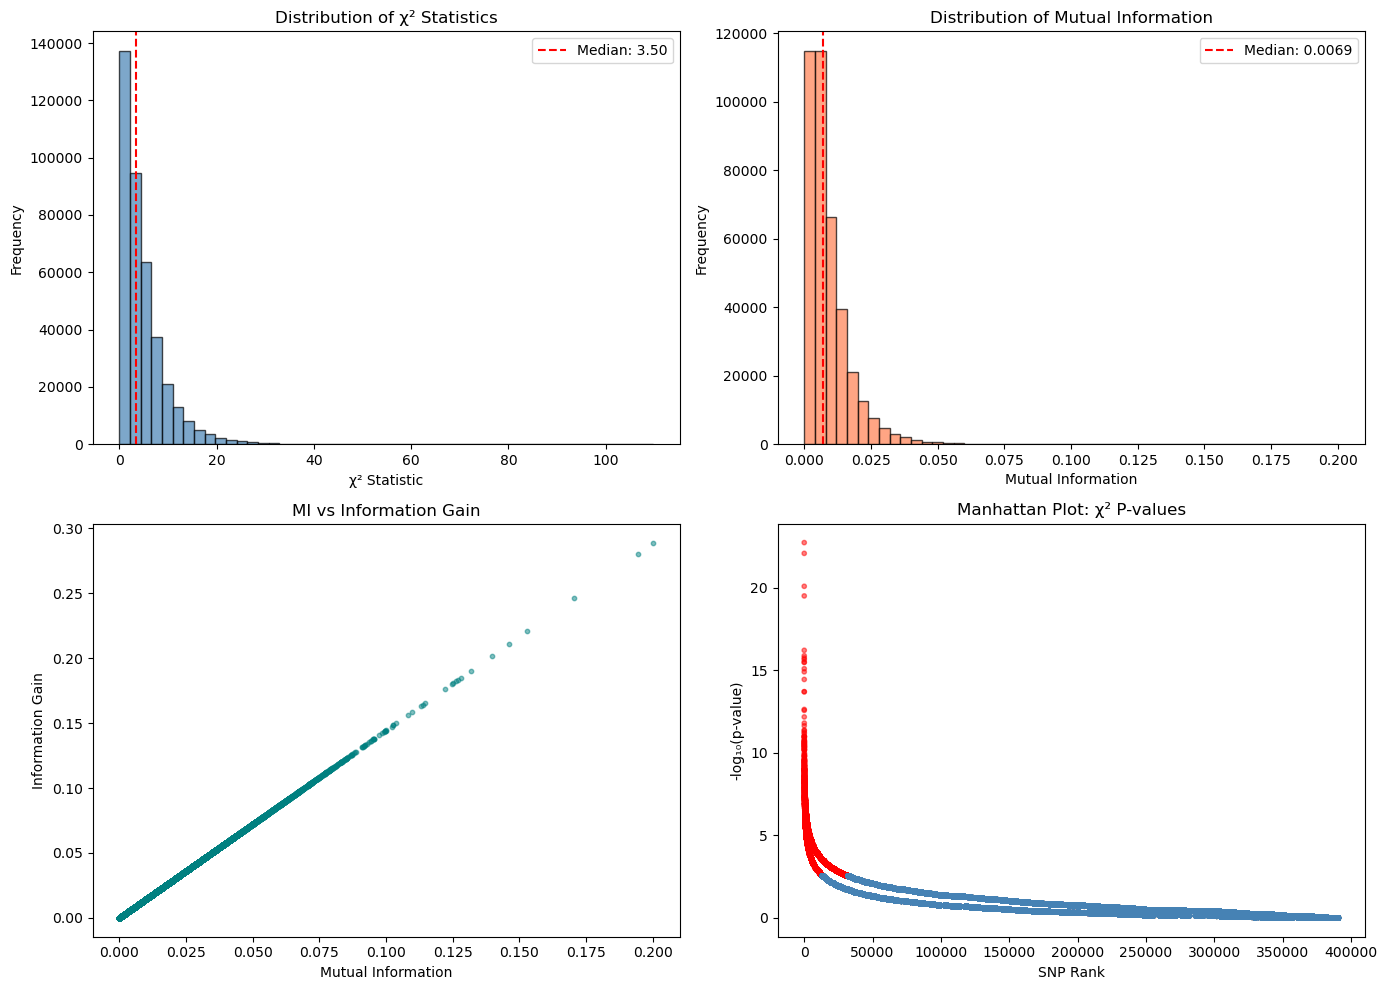

In [14]:
# Visualization panel
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: χ² distribution
ax = axes[0, 0]
ax.hist(results_df['chi2'].dropna(), bins=50, color='steelblue', edgecolor='black', alpha=0.7)
ax.axvline(results_df['chi2'].median(), color='red', linestyle='--', 
           label=f'Median: {results_df["chi2"].median():.2f}')
ax.set_xlabel('χ² Statistic')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of χ² Statistics')
ax.legend()

# Plot 2: MI distribution
ax = axes[0, 1]
ax.hist(results_df['mutual_information'].dropna(), bins=50, color='coral', edgecolor='black', alpha=0.7)
ax.axvline(results_df['mutual_information'].median(), color='red', linestyle='--',
           label=f'Median: {results_df["mutual_information"].median():.4f}')
ax.set_xlabel('Mutual Information')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Mutual Information')
ax.legend()

# Plot 3: MI vs IG correlation
ax = axes[1, 0]
ax.scatter(results_df['mutual_information'], results_df['information_gain'], 
           alpha=0.5, s=10, c='teal')
ax.set_xlabel('Mutual Information')
ax.set_ylabel('Information Gain')
ax.set_title('MI vs Information Gain')

# Plot 4: -log10(p-value) Manhattan-style
ax = axes[1, 1]
log_p = -np.log10(results_df['chi2_pvalue'].clip(lower=1e-300))
sorted_df = results_df.sort_values('chi2', ascending=False).reset_index(drop=True)
colors = ['red' if sig else 'steelblue' for sig in sorted_df['chi2_significant_fdr']]
ax.scatter(range(len(sorted_df)), -np.log10(sorted_df['chi2_pvalue'].clip(lower=1e-300)),
           c=colors, alpha=0.5, s=10)
ax.set_xlabel('SNP Rank')
ax.set_ylabel('-log₁₀(p-value)')
ax.set_title('Manhattan Plot: χ² P-values')

plt.tight_layout()
plt.show()

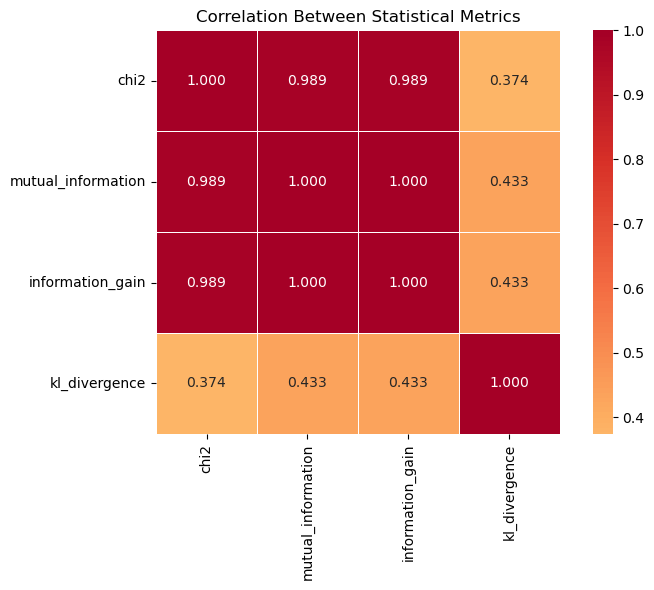

In [15]:
# Correlation heatmap
metric_cols = ['chi2', 'mutual_information', 'information_gain', 'kl_divergence']
corr_matrix = results_df[metric_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='RdYlBu_r', center=0,
            fmt='.3f', square=True, linewidths=0.5)
plt.title('Correlation Between Statistical Metrics')
plt.tight_layout()
plt.show()

## Step 7: Select Top SNPs and Create Ranking

In [16]:
# Create composite ranking
results_df['rank_chi2'] = results_df['chi2'].rank(ascending=False)
results_df['rank_mi'] = results_df['mutual_information'].rank(ascending=False)
results_df['rank_ig'] = results_df['information_gain'].rank(ascending=False)
results_df['rank_kl'] = results_df['kl_divergence'].rank(ascending=False)

# Average rank (lower is better)
results_df['composite_rank'] = (results_df['rank_chi2'] + results_df['rank_mi'] + 
                                 results_df['rank_ig'] + results_df['rank_kl']) / 4

# Add consensus count column
results_df['tests_passed'] = results_df['snp_id'].apply(lambda x: snp_counts.get(x, 0))

# Filter for SNPs that passed ALL 4 tests
results_df_all4 = results_df[results_df['tests_passed'] == 4].copy()
results_df_all4_sorted = results_df_all4.sort_values('composite_rank')

# Also keep full sorted results for reference
results_df_sorted = results_df.sort_values('composite_rank')

print(f"SNPs passing ALL 4 tests: {len(results_df_all4_sorted)}")
print(f"\nTop 25 SNPs (All 4 Tests Passed):")
print("="*80)
display(results_df_all4_sorted[['snp_id', 'chi2', 'mutual_information', 'information_gain', 
                                 'kl_divergence', 'composite_rank', 'tests_passed']].head(25))

SNPs passing ALL 4 tests: 37

Top 25 SNPs (All 4 Tests Passed):


,snp_id,chi2,mutual_information,information_gain,kl_divergence,composite_rank,tests_passed
0,"4:101002868[b37]A,T",78.693340,0.139602,0.201404,3.986245,5.500,4
1,"14:96938945[b37]A,T",72.124959,0.126845,0.182999,4.392354,7.500,4
2,"4:17813761[b37]G,A",74.685986,0.126343,0.182274,2.866247,8.750,4
3,"1:12387655[b37]G,A",73.169304,0.124793,0.180038,3.084214,9.500,4
4,"5:41181491[b37]G,T",69.545455,0.122297,0.176437,4.242747,10.250,4
5,"12:128054516[b37]C,T",65.213917,0.113111,0.163185,3.038563,13.250,4
6,"3:130239945[b37]G,A",45.926909,0.102753,0.148242,4.219180,33.500,4
7,"6:37497412[b37]C,T",45.808948,0.081229,0.117188,2.384240,69.750,4
8,"16:10424828[b37]A,G",48.017459,0.081116,0.117026,1.787127,77.750,4
9,"1:168205652[b37]G,A",46.919179,0.079313,0.114425,1.932013,81.000,4


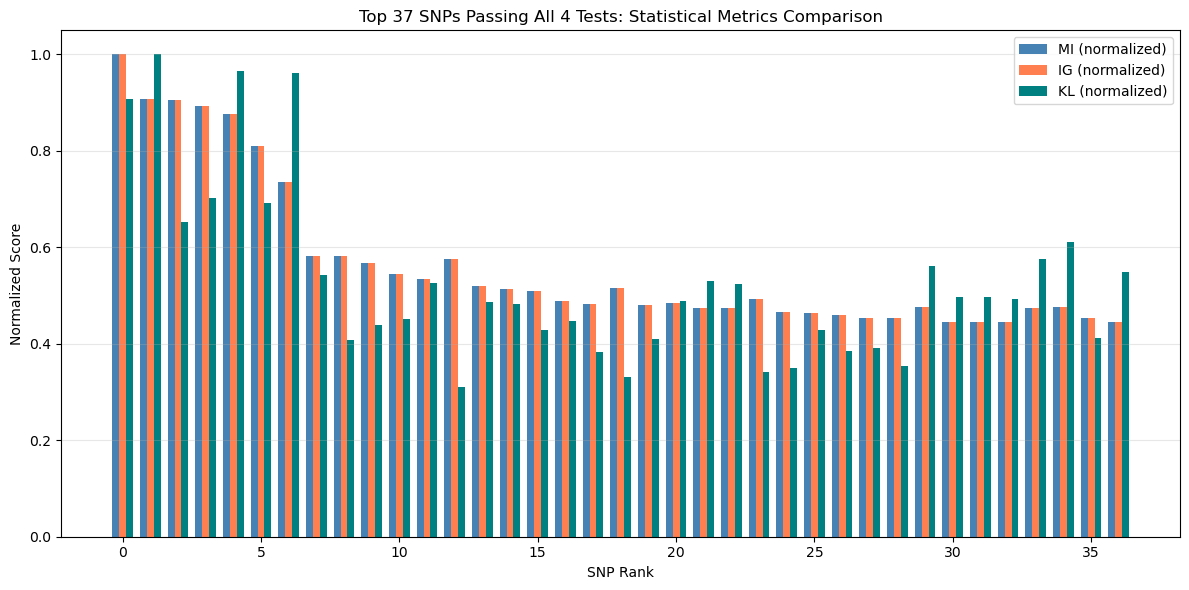


Total SNPs passing all 4 tests: 37


In [17]:
# Top SNPs visualization (using SNPs that passed all 4 tests)
fig, ax = plt.subplots(figsize=(12, 6))

top_snps = results_df_all4_sorted
n_display = min(50, len(top_snps))
x = np.arange(n_display)

if len(top_snps) > 0:
    # Normalize metrics for comparison
    mi_norm = top_snps['mutual_information'].head(n_display) / top_snps['mutual_information'].max()
    ig_norm = top_snps['information_gain'].head(n_display) / top_snps['information_gain'].max()
    kl_norm = top_snps['kl_divergence'].head(n_display) / top_snps['kl_divergence'].max()

    width = 0.25
    ax.bar(x - width, mi_norm, width, label='MI (normalized)', color='steelblue')
    ax.bar(x, ig_norm, width, label='IG (normalized)', color='coral')
    ax.bar(x + width, kl_norm, width, label='KL (normalized)', color='teal')

    ax.set_xlabel('SNP Rank')
    ax.set_ylabel('Normalized Score')
    ax.set_title(f'Top {n_display} SNPs Passing All 4 Tests: Statistical Metrics Comparison')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
else:
    ax.text(0.5, 0.5, 'No SNPs passed all 4 tests', ha='center', va='center', transform=ax.transAxes)
    ax.set_title('No SNPs Passed All 4 Tests')

plt.tight_layout()
plt.show()

print(f"\nTotal SNPs passing all 4 tests: {len(results_df_all4_sorted)}")

## Step 8: Save Results

In [18]:
# Save full results
output_path = str(PATHS.OUTPUT_DIR / "statistical_snp_scores_02b.csv")
results_df_sorted.to_csv(output_path, index=False)
print(f"Full results saved: {output_path}")

# Save SNPs that passed ALL 4 tests (primary output)
all4_snps_path = str(PATHS.OUTPUT_DIR / "statistical_all4_snps_02b.csv")
results_df_all4_sorted.to_csv(all4_snps_path, index=False)
print(f"SNPs passing all 4 tests saved: {all4_snps_path} ({len(results_df_all4_sorted)} SNPs)")

# Save SNP IDs only (for PLINK extraction) - using all 4 tests filter
all4_ids_path = str(PATHS.OUTPUT_DIR / "statistical_all4_snp_ids_02b.txt")
results_df_all4_sorted[['snp_id']].to_csv(all4_ids_path, index=False, header=False)
print(f"All-4-tests SNP IDs saved: {all4_ids_path}")

# Also save top N for backward compatibility
top_n = SITUATIONAL_FILTERS.FST_TOP_N
top_snps_df = results_df_sorted.head(top_n)
top_snps_path = str(PATHS.OUTPUT_DIR / "statistical_top_snps_02b.csv")
top_snps_df.to_csv(top_snps_path, index=False)
print(f"Top {top_n} SNPs (by rank) saved: {top_snps_path}")

top_ids_path = str(PATHS.OUTPUT_DIR / "statistical_top_snp_ids_02b.txt")
top_snps_df[['snp_id']].to_csv(top_ids_path, index=False, header=False)
print(f"Top {top_n} SNP IDs saved: {top_ids_path}")

# Save ML data with ONLY all-4-tests SNPs (memory efficient for downstream ML)
all4_snp_ids = results_df_all4_sorted['snp_id'].tolist()
available_all4_snps = [s for s in all4_snp_ids if s in genotype_df.columns]
ml_cols = ['sample', 'pop'] + available_all4_snps
ml_data_all4 = genotype_df[ml_cols]

ml_data_path = str(PATHS.OUTPUT_DIR / "statistical_ml_data_02b.csv")
ml_data_all4.to_csv(ml_data_path, index=False)
print(f"ML data (all-4-tests SNPs only) saved: {ml_data_path}")
print(f"  → {len(available_all4_snps)} SNPs, {len(ml_data_all4)} samples")

Full results saved: 1000genomes/output/statistical_snp_scores_02b.csv
SNPs passing all 4 tests saved: 1000genomes/output/statistical_all4_snps_02b.csv (37 SNPs)
All-4-tests SNP IDs saved: 1000genomes/output/statistical_all4_snp_ids_02b.txt
Top 1000 SNPs (by rank) saved: 1000genomes/output/statistical_top_snps_02b.csv
Top 1000 SNP IDs saved: 1000genomes/output/statistical_top_snp_ids_02b.txt
ML data (all-4-tests SNPs only) saved: 1000genomes/output/statistical_ml_data_02b.csv
  → 37 SNPs, 306 samples


In [19]:
# Cleanup temp VCF
import os
temp_vcf = f"{vcf_output}.vcf"
temp_log = f"{vcf_output}.log"

if os.path.exists(temp_vcf):
    os.remove(temp_vcf)
    print(f"Removed: {temp_vcf}")
if os.path.exists(temp_log):
    os.remove(temp_log)
    print(f"Removed: {temp_log}")

Removed: 1000genomes/output/statistical_analysis_temp.vcf
Removed: 1000genomes/output/statistical_analysis_temp.log


## Summary

In [20]:
print("="*70)
print("STATISTICAL SNP SELECTION SUMMARY")
print("="*70)

print(f"\nInput:")
print(f"  Pfile: {INPUT_PFILE}")
print(f"  Samples: {len(genotype_df)}")
print(f"  SNPs analyzed: {len(snp_columns)}")
print(f"  Populations: {list(populations.unique())}")

print(f"\nStatistical Tests:")
print(f"  1. Pearson χ² test (FDR corrected)")
print(f"  2. Mutual Information (top 500)")
print(f"  3. Information Gain (top 500)")
print(f"  4. KL Divergence (top 500)")

print(f"\nFiltering Results:")
print(f"  χ² FDR significant: {results_df['chi2_significant_fdr'].sum()}")
print(f"  Consensus (≥2 tests): {len(snps_in_2)}")
print(f"  Consensus (≥3 tests): {len(snps_in_3)}")
print(f"  ★ Passed ALL 4 tests: {len(snps_in_4)}")

if len(results_df_all4_sorted) > 0:
    print(f"\nTop SNP (All 4 Tests):")
    top = results_df_all4_sorted.iloc[0]
    print(f"  {top['snp_id']}")
    print(f"  χ²: {top['chi2']:.2f}, MI: {top['mutual_information']:.4f}")
    print(f"  IG: {top['information_gain']:.4f}, KL: {top['kl_divergence']:.4f}")

print(f"\nOutput Files:")
print(f"  - statistical_snp_scores_02b.csv (all results)")
print(f"  - statistical_all4_snps_02b.csv ({len(results_df_all4_sorted)} SNPs passing all 4 tests) ★")
print(f"  - statistical_all4_snp_ids_02b.txt (IDs for PLINK extraction) ★")
print(f"  - statistical_top_snps_02b.csv (top {top_n} by composite rank)")
print(f"  - statistical_ml_data_02b.csv (genotype matrix)")

print(f"\nNext Steps:")
print(f"  Option A: Run 03_fst_and_pca.ipynb (FST-based selection)")
print(f"  Option B: Run 04_ml_training.ipynb with all-4-tests SNPs")
print(f"  Option C: Compare both methods in 04b_ml_training_statistical.ipynb")

STATISTICAL SNP SELECTION SUMMARY

Input:
  Pfile: 1000genomes/output/EAS_FINAL_DATA_FOR_FST
  Samples: 306
  SNPs analyzed: 390615
  Populations: ['KHV', 'CHB', 'JPT']

Statistical Tests:
  1. Pearson χ² test (FDR corrected)
  2. Mutual Information (top 500)
  3. Information Gain (top 500)
  4. KL Divergence (top 500)

Filtering Results:
  χ² FDR significant: 22096
  Consensus (≥2 tests): 919
  Consensus (≥3 tests): 500
  ★ Passed ALL 4 tests: 37

Top SNP (All 4 Tests):
  4:101002868[b37]A,T
  χ²: 78.69, MI: 0.1396
  IG: 0.2014, KL: 3.9862

Output Files:
  - statistical_snp_scores_02b.csv (all results)
  - statistical_all4_snps_02b.csv (37 SNPs passing all 4 tests) ★
  - statistical_all4_snp_ids_02b.txt (IDs for PLINK extraction) ★
  - statistical_top_snps_02b.csv (top 1000 by composite rank)
  - statistical_ml_data_02b.csv (genotype matrix)

Next Steps:
  Option A: Run 03_fst_and_pca.ipynb (FST-based selection)
  Option B: Run 04_ml_training.ipynb with all-4-tests SNPs
  Option C: Co